# 5.2 LSTM and GRU

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [2]:
%matplotlib inline

## U5.02 - Long Short Term Memory RNN

The main drawback of conventional RNNs is its inability to learn long term dependency, or even the capacity of capturing long and short dependences at the same time.

Remenber that in a RNN:

$${\bf{a}}^{(t)} = {\bf{b}} + {\bf{V}}{\bf{h}}^{(t-1)} + {\bf{U}}{\bf{x}}^{(t)},\\ {\bf{h}}^{(t)} = \tanh({\bf{a}}^{(t)}), \\ {\bf{o}}^{(t)} = {\bf{c}} + {\bf{W}}{\bf{h}}^{(t)}$$

and,

$$ \nabla_{{\bf{h}}^{(t)}}L = {\bf{V}}^T\text{diag} \left( 1 - \left( {\bf{h}}^{(t+1)} \right)^2\right)(\nabla_{{\bf{h}}^{(t+1)}} L) + {\bf{W}}^T(\nabla_{{\bf{o}}^{(t)}}L)$$

and,

$$\nabla_{\bf V}L = \sum_t \text{diag}\left( 1 - \left( {\bf{h}}^{(t)} \right)^2\right)(\nabla_{{\bf{h}}^{(t)}} L){\bf{h}}^{(t-1)^T}$$

Therefore, during the training phase of one time series, the matrix $\bf{V}$, which contains the weights of the feedback loop, mulplies by itself $(\tau-1)$ times. Thus, if its values are close to zero, the weights end up vanishing. On the contrary, if the weights of $\bf{V}$ are to large, they end up diverging (in case of no regularization method be included). This fact makes conventional RNNs very unstable.

They are also very sensitive to vanishing gradients phenomena, but it can be overcome by using Relu or LeakyRelu activation functions.

**LSTMs** are a type of RNNs proposed to takle the former problems. They were introduced in 1997 and are based on different type of basic unit called **cell**.

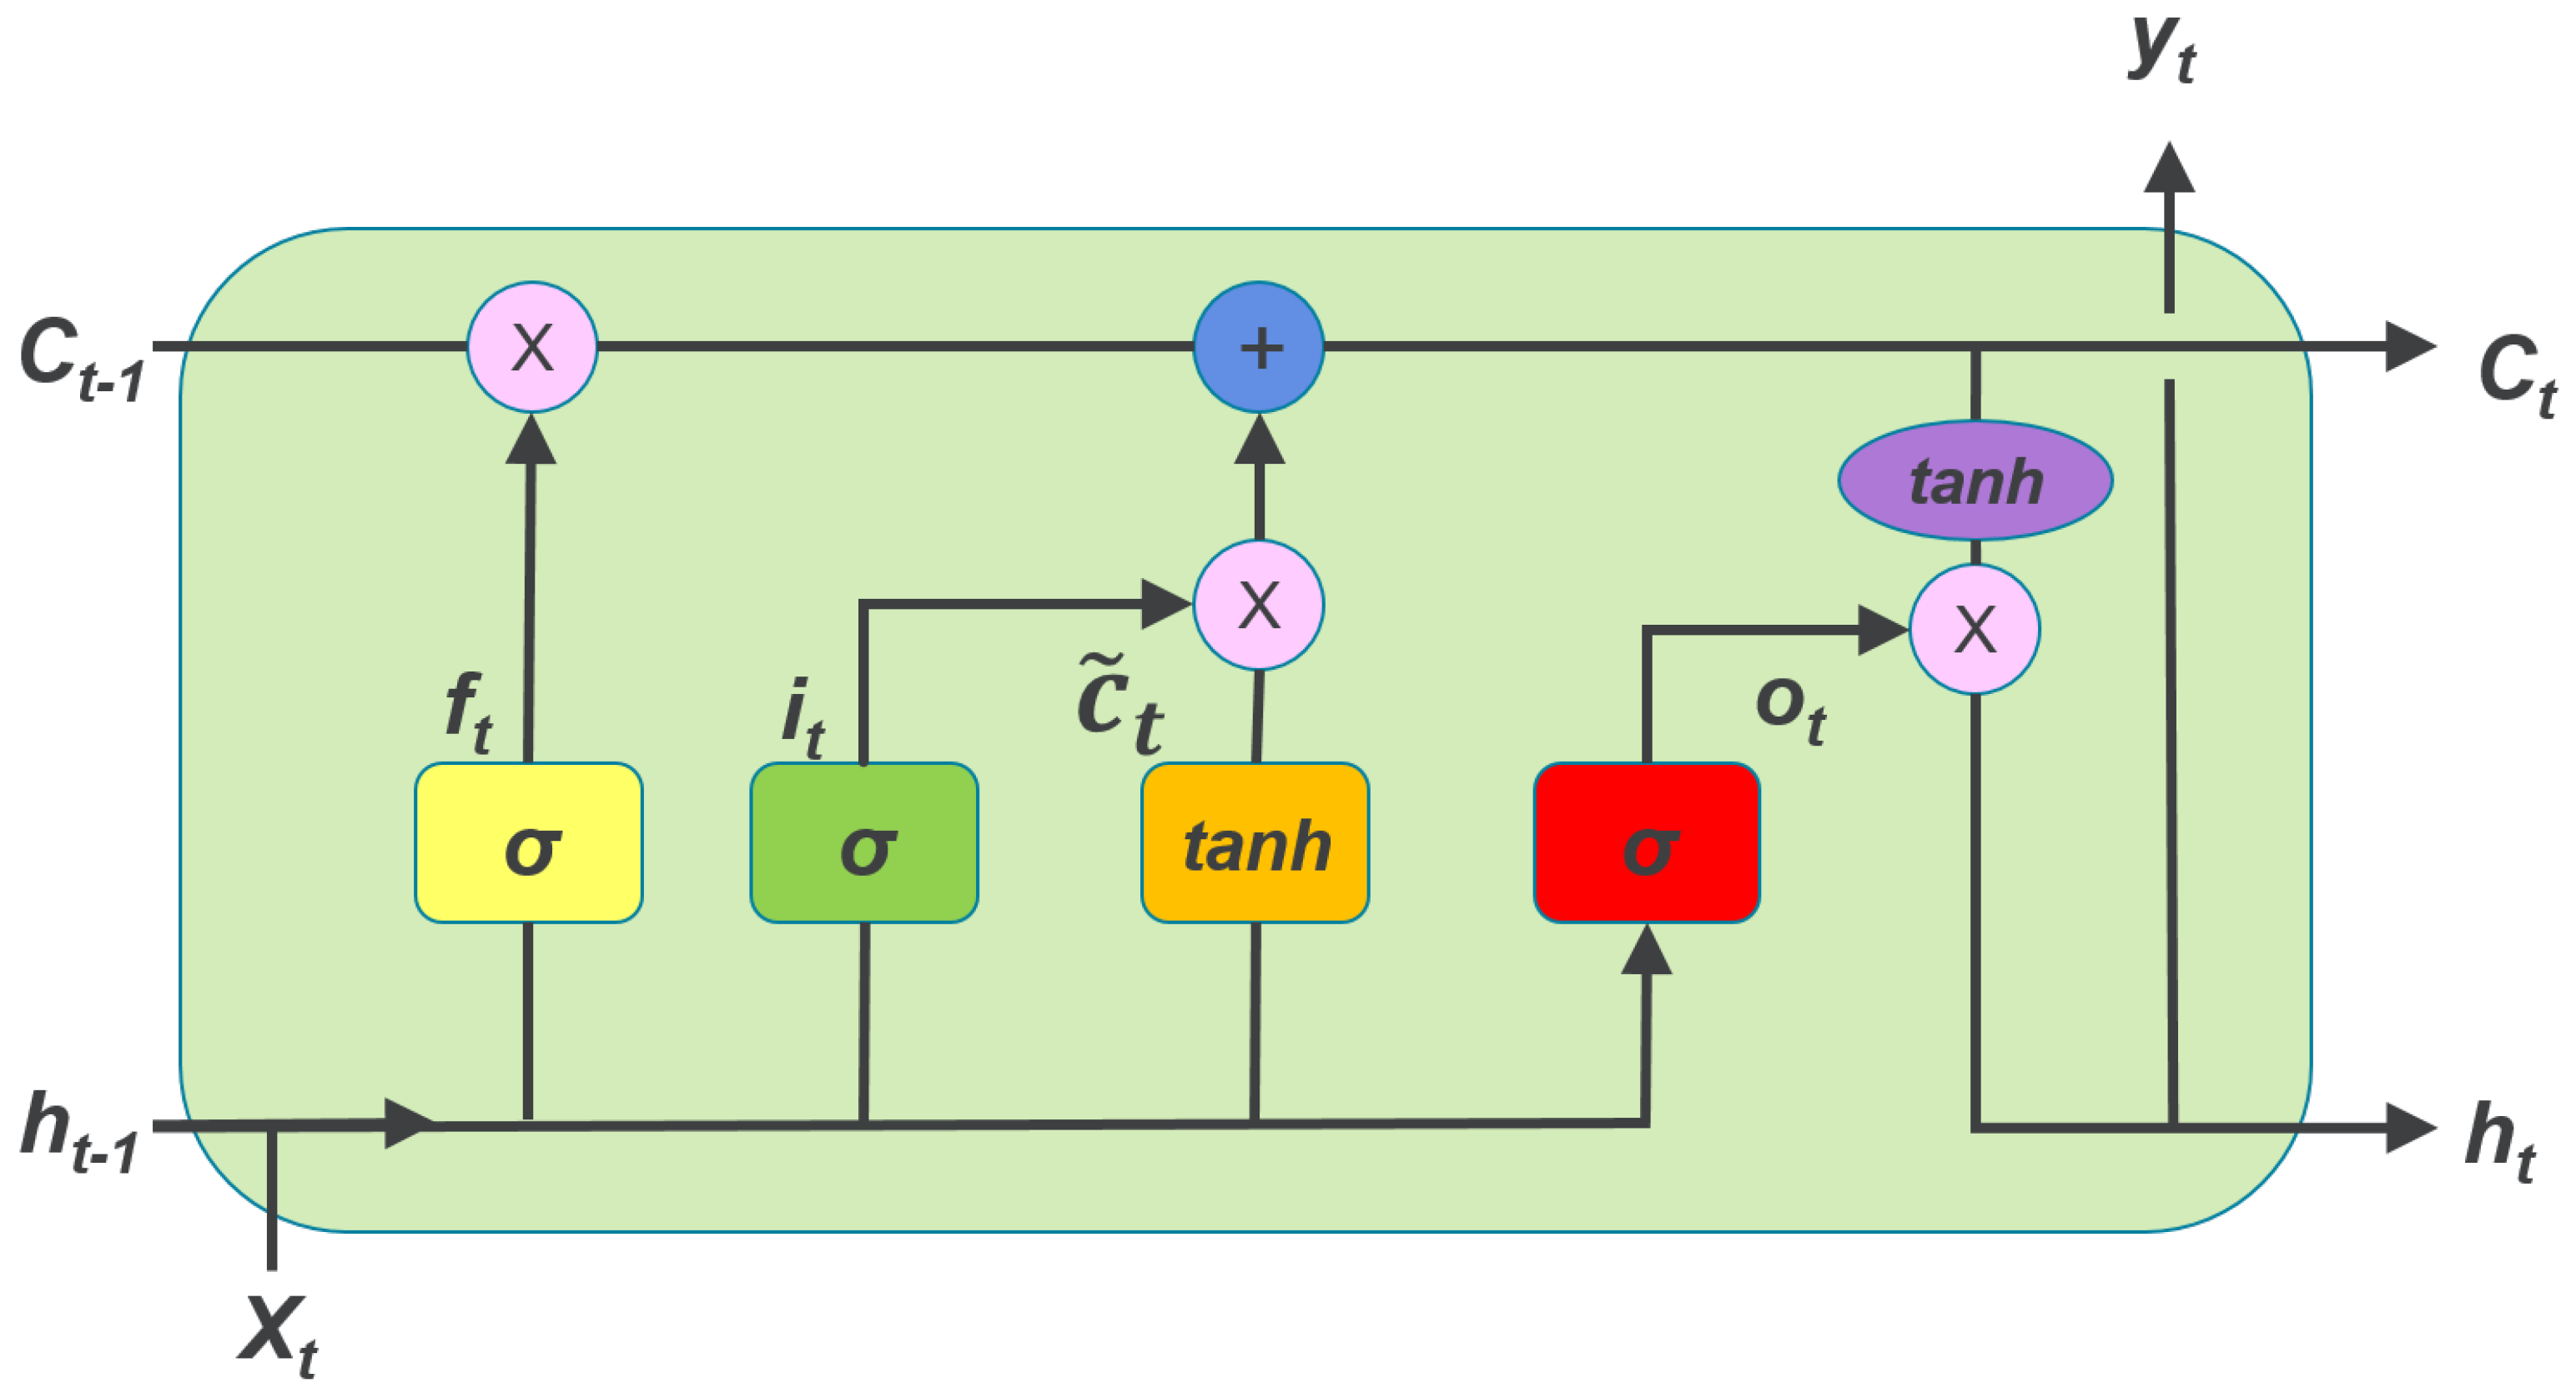

In [3]:
from IPython.display import Image
Image(filename='local/imgs/LSTM2.png', width=1200)

The cells use the principle of cumulative average called **Exponential Weighted Moving Average (EWMA)** originally proposed for a type of units called leaky units. EWMA takes into account more or less information from the past based on a $\beta$ paratemer. The rule is given by: $\mu^{(t)} \leftarrow \beta \mu^{(t-1)} + (1 - \beta)\upsilon^{(t)}$. 

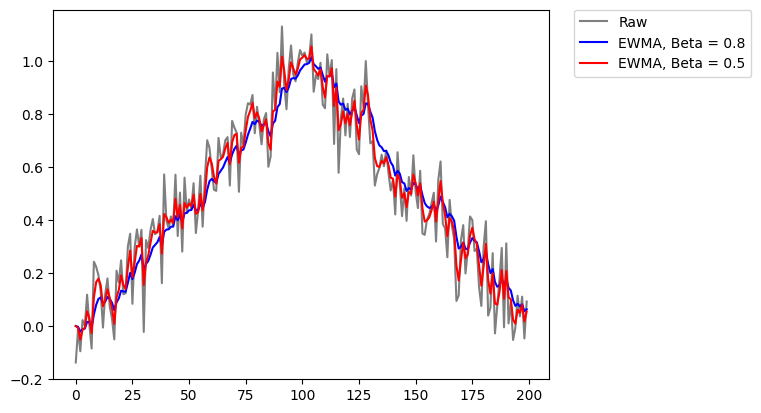

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
# make a hat function, and add noise
x = np.linspace(0,1,100)
x = np.hstack((x,x[::-1]))
x += np.random.normal( loc=0, scale=0.1, size=200 )
plt.plot( x, 'k', alpha=0.5, label='Raw' )
 
Beta1 = 0.8
Beta2 = 0.5
x1 = np.zeros(200)
x2 = np.copy(x1)
for i in range(1,200):
    x1[i] = Beta1*x1[i-1] + (1-Beta1)*x[i]
    x2[i] = Beta2*x2[i-1] + (1-Beta2)*x[i]
# regular EWMA, with bias against trend
plt.plot( x1, 'b', label='EWMA, Beta = 0.8' )
 
# "corrected" (?) EWMA
plt.plot( x2, 'r', label='EWMA, Beta = 0.5' )
 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#savefig( 'ewma_correction.png', fmt='png', dpi=100 )

The LSTM network uses the same principle the level of memory or time dependence, but instead of one controling parameter, it define **gates** adjusted during the training phase. 

Every cell LSTM contains three gates (the three $\sigma's$ in the former graph):

- The first step in the LSTM is to decide what information is going to be throwed away from the cell state. This decision is made by a sigmoid layer called the **forget gate layer.** It looks at $h_{t−1}$ and $x_t$, and outputs a number between 0 and 1 for each number in the cell state $C_{t−1}$. A 1 represents “completely keep this” while a 0 represents “completely get rid of this.”

$$f_l^{(t)} = \sigma \left( b_l^f + \sum_j U_{l,j}^f x_j^{(t)} + \sum_j V_{l,j}^f h_j^{(t-1)}\right)$$

- The next step is to decide what new information is going to be stored in the cell state. This has two parts. First, a sigmoid layer called the **input gate layer** decides which values will be updated. Next, a tanh layer creates a vector of new candidate values, $\tilde{C}_t$, that could be added to the state.

$$i_l^{(t)} = \sigma \left( b_l^i + \sum_j U_{l,j}^i x_j^{(t)} + \sum_j V_{l,j}^i h_j^{(t-1)}\right)$$

- Finally, the cell decides what is going to output. This output will be based on the cell state, but will be a filtered version. First, it runs a **output gate layer** which decides what part of the cell state is going to output. Then, the cell state is passed through a tanh function (to push the values to be between −1 and 1) and multiplied it by the output of the gate.

$$o_l^{(t)} = \sigma \left( b_l^o + \sum_j U_{l,j}^o x_j^{(t)} + \sum_j V_{l,j}^o h_j^{(t-1)}\right)$$

Based on these gates, the state of the cell and output of the cell can be calculated as:

$$ c_l^{(t)} = f_l^{(t)}c_l^{(t-1)} + i_l^{(t)}\tanh \left( b_l^c + \sum_j U_{l,j}^c x_j^{(t)} + \sum_j V_{l,j}^c h_j^{(t-1)} \right)$$

$$h_l^{(t)} = \tanh(c_l^{(t)})o_l^{(t)}$$

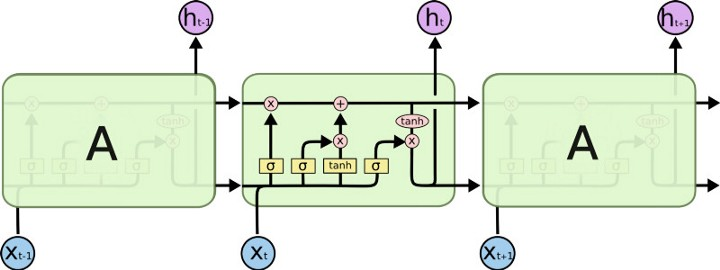

In [5]:
Image(filename='local/imgs/LSTM2.jpeg', width=1200)

In [5]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN, Input
import math
from sklearn.metrics import mean_squared_error

In [6]:
# First, we get the data
dataset = pd.read_csv('local/data/KO_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,20.40,20.50,20.18,20.45,13640800,KO
2006-01-04,20.50,20.54,20.33,20.41,19993200,KO
2006-01-05,20.36,20.56,20.29,20.51,16613400,KO
2006-01-06,20.53,20.78,20.43,20.70,17122800,KO
2006-01-09,20.74,20.84,20.62,20.80,13819800,KO


In [7]:
# Checking for missing values
training_set = dataset[:'2015'].iloc[:,1:2].values
test_set = dataset['2016':].iloc[:,1:2].values
test_set[np.isnan(test_set)] = dataset['High'].max()

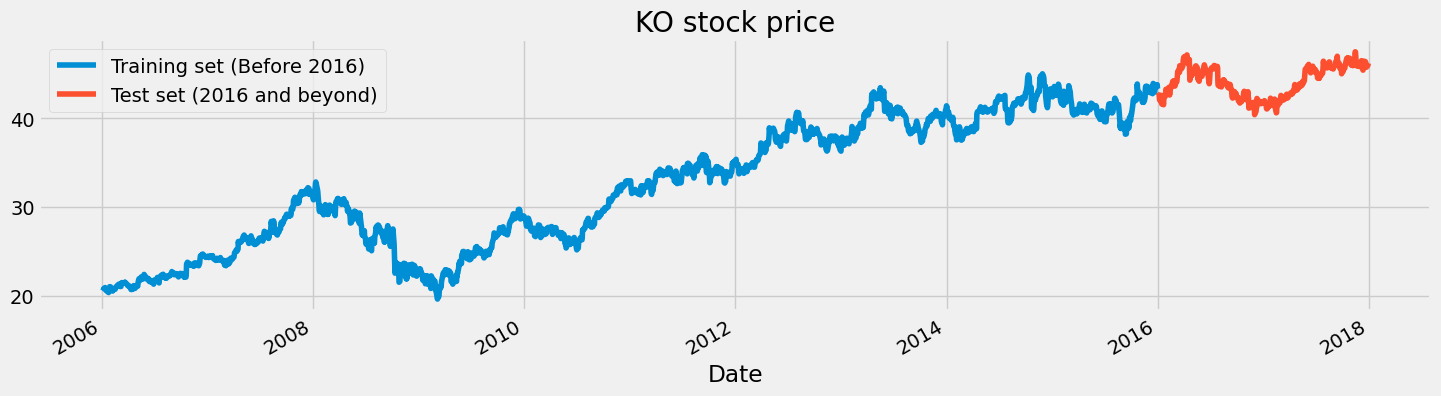

In [8]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2015'].plot(figsize=(16,4),legend=True)
dataset["High"]['2016':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2016)','Test set (2016 and beyond)'])
plt.title('KO stock price')
plt.show()

In [9]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [10]:
from local.lib.DataPreparationRNN import create_dataset
look_back = 10
X_train, y_train = create_dataset(training_set_scaled, look_back)
print(X_train.shape)
print(y_train.shape)

(2507, 10)
(2507,)


In [11]:
# The RNN architecture
model = Sequential()
model.add(Input(shape=(X_train.shape[1],1)))
# First RNN layer with Dropout regularisation
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

Let's remember what a RNN can do:

In [13]:
# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 0.0611 
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 0.0064
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0046
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0040
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 0.0035
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0030
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0029
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 0.0027
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0026
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 0.0026
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 0.0025
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0021
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 0.0020
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0019
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - l

In [15]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - look_back:].values
inputs[np.isnan(inputs)] = dataset['High'].max()
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs.shape

(513, 1)

In [16]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(look_back,inputs.shape[0]):
    X_test.append(inputs[i-look_back:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


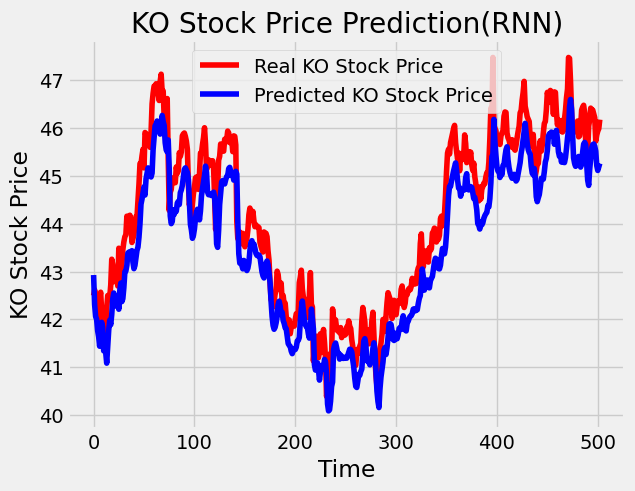

In [17]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('KO Stock Price Prediction(RNN)')
plt.xlabel('Time')
plt.ylabel('KO Stock Price')
plt.legend()
plt.show()

In [18]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.7130857635072282.


Now using a LSTM:

In [19]:
# The LSTM architecture
regressor = Sequential()
regressor.add(Input(shape=(X_train.shape[1],1)))
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1))

In [20]:
regressor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1272
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.0066
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0048  
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043  
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040  
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.0038
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.0035
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.0035
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.0037
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.0033
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.0028
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032  
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026  
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 

In [22]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


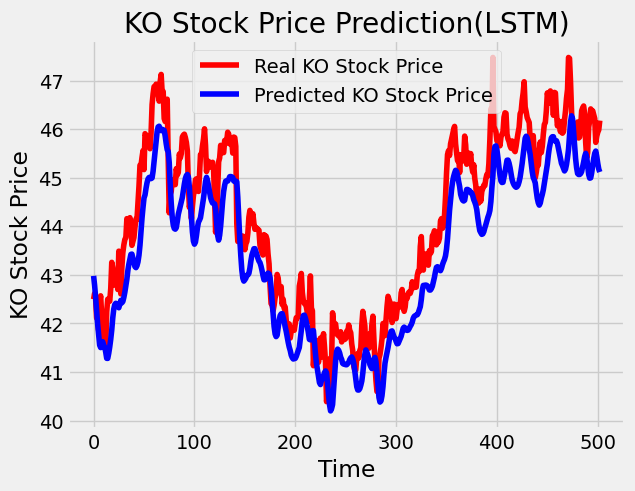

In [23]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('KO Stock Price Prediction(LSTM)')
plt.xlabel('Time')
plt.ylabel('KO Stock Price')
plt.legend()
plt.show()

In [24]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.8338981916716676.


## Gated Recurrent Units

The GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results. [Source](https://www.kaggle.com/honeysingh/intro-to-recurrent-neural-networks-lstm-gru/notebook)

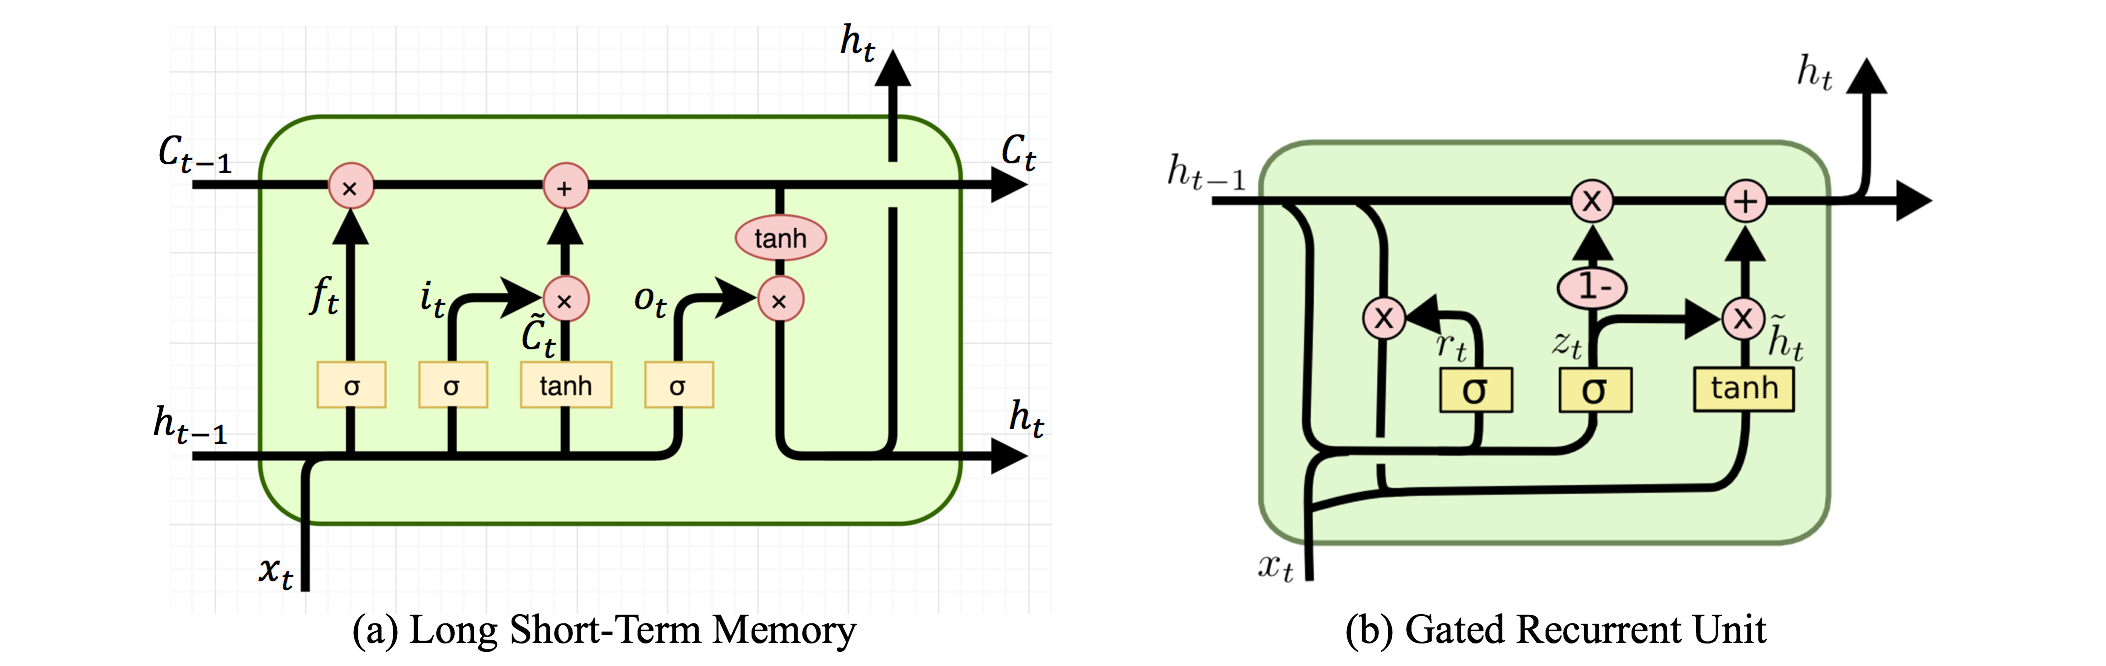

In [25]:
Image(filename='local/imgs/lstmandgru.png', width=1200)

[Source](https://isaacchanghau.github.io/post/lstm-gru-formula/)

$$z_t = \sigma(x_t U^z + h_{t-1} V^z)$$

$$r_t = \sigma(x_t U^r + h_{t-1} V^r)$$

$$\tilde{h}_t = \tanh(x_t U^h +(r_t h^{t−1}) W^h)$$

$$ h_t = (1-z_t)h_{t-1} + z_t \tilde{h}_t$$

Here $r$ is a reset gate, and $z$ is an update gate. Intuitively, the reset gate determines how to combine the new input with the previous memory, and the update gate defines how much of the previous memory to keep around. If set the reset to all 1’s and update gate to all 0’s, it will arrive at the vanilla RNN model.

In [26]:
# The GRU architecture
regressor2 = Sequential()
regressor2.add(Input(shape=(X_train.shape[1],1)))
# First GRU layer with Dropout regularisation
regressor2.add(GRU(units=50))
regressor2.add(Dropout(0.3))
# The output layer
regressor2.add(Dense(units=1))

In [27]:
regressor2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compiling the RNN
regressor2.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor2.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0943
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0055
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0048
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022
Epoch 16/50
79/79 ━

**Note** that the every epoch runs a little bit faster than in the LSTM model.

In [29]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


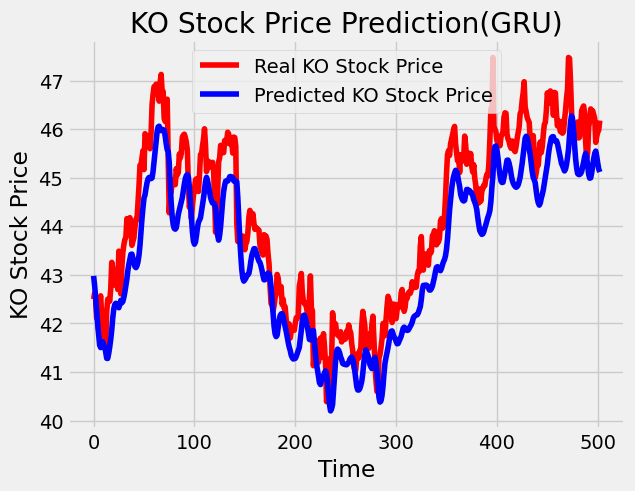

In [30]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('KO Stock Price Prediction(GRU)')
plt.xlabel('Time')
plt.ylabel('KO Stock Price')
plt.legend()
plt.show()

In [31]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.8338981916716676.


Interesting readings:

 - Understanding LSTM Networks. http://colah.github.io/posts/2015-08-Understanding-LSTMs/